In [40]:
# import all functions from utils.py
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# first, let us define a molecule using pySCF notation

atom = "H 0 0 0; H 0 0 0.74" # equilibrium bond length H2
basis = "sto-3g"
charge = 0
spin = 0

# and construct its Hamiltonian in qubit form using the Jordan-Wigner transform
unsimplified_hamiltonian = get_unsimplified_hamiltonian(atom, basis, charge, spin)

In [42]:
# we can inspect our Hamiltonian, which is of OpenFermion QubitOperator type
print(type(unsimplified_hamiltonian),"\n")
print(unsimplified_hamiltonian)

<class 'openfermion.ops.operators.qubit_operator.QubitOperator'> 

(-0.09706626816763164+0j) [] +
(-0.04530261550379926+0j) [X0 X1 Y2 Y3] +
(0.04530261550379926+0j) [X0 Y1 Y2 X3] +
(0.04530261550379926+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379926+0j) [Y0 Y1 X2 X3] +
(0.17141282644776912+0j) [Z0] +
(0.16868898170361205+0j) [Z0 Z1] +
(0.12062523483390412+0j) [Z0 Z2] +
(0.1659278503377034+0j) [Z0 Z3] +
(0.17141282644776917+0j) [Z1] +
(0.16592785033770338+0j) [Z1 Z2] +
(0.12062523483390412+0j) [Z1 Z3] +
(-0.22343153690813441+0j) [Z2] +
(0.17441287612261572+0j) [Z2 Z3] +
(-0.22343153690813444+0j) [Z3]


In [43]:
# we can use OpenFermion's QubitOperator functions to get details about our unsimplified Hamiltonian, e.g.,

from openfermion.utils import count_qubits
print(count_qubits(unsimplified_hamiltonian))

4


In [44]:
# lets now construct a symmetry adapted version of our Hamiltonian and compare

simplified_hamiltonian = get_simplified_hamiltonian(atom, basis, charge, spin)

print(count_qubits(simplified_hamiltonian),"\n")
print(simplified_hamiltonian)

1 

(-0.3270705806846189+0j) [] +
(0.18121046201519705+0j) [X0] +
(-0.7896887267118071+0j) [Z0]


In [45]:
# now let's apply the XBK method to both of our Hamiltonians

r_value = 2

unsimplified_ground_state_energy, unsimplified_ground_state, unsimplified_ising_hamiltonian = calculate_ising_ground_state(unsimplified_hamiltonian, r_value)
simplified_ground_state_energy, simplified_ground_state, simplified_ising_hamiltonian = calculate_ising_ground_state(simplified_hamiltonian, r_value)

# and compare the energies and number of qubits each Hamiltonian uses

print(f"No Symmetry-Adapted Encoding:\nGround State Energy {unsimplified_ground_state_energy}, Number of Qubits: {count_qubits(unsimplified_ising_hamiltonian)}\n")
print(f"With Symmetry-Adapted Encoding:\nGround State Energy {unsimplified_ground_state_energy}, Number of Qubits: {count_qubits(unsimplified_ising_hamiltonian)}")

No Symmetry-Adapted Encoding:
Ground State Energy -1.1167593073964284, Number of Qubits: 8

With Symmetry-Adapted Encoding:
Ground State Energy -1.1167593073964284, Number of Qubits: 8


In [46]:
# we can compare with FCI for a range of bond lengths for a different molecule (LiH)

from pyscf import gto, scf, fci
from openfermion.linalg import get_ground_state, get_sparse_operator

bond_lengths = np.linspace(0.5, 3.0, 25)

fci_energies = []
unsimp_qubit_energies = []
simp_qubit_energies = []
unsimp_ising_energies = []
simp_ising_energies = []

for bond_length in bond_lengths:
    
    # FCI calculation
    mol = gto.Mole()
    mol.build(
        atom = f'Li 0 0 0; H 0 0 {bond_length}', 
        basis = 'sto-3g', 
        unit = 'angstrom'
    )

    mf = scf.UHF(mol)
    mf.kernel()

    cisolver = fci.FCI(mf)
    fci_energy = cisolver.kernel()[0]
    fci_energies+= [fci_energy]
     
    # construct pySCF geometry using our return_geomtery() function
    atom = return_geometry("LiH", bond_length)
    
    # construct hamiltonians
    unsimp_ham = get_unsimplified_hamiltonian(atom, basis, charge, spin)
    simp_ham = get_simplified_hamiltonian(atom, basis, charge, spin)
    
    # do diagonalization on qubit Hamiltonians before XBK transform
    
    unsimp_qubit_energy, _ = get_ground_state(get_sparse_operator(unsimp_ham))
    simp_qubit_energy, _ = get_ground_state(get_sparse_operator(simp_ham))
    
    unsimp_qubit_energies += [unsimp_qubit_energy]
    simp_qubit_energies += [simp_qubit_energy]
    
    # apply XBK method
    
    unsimp_ising_energy, _, _ = calculate_ising_ground_state(unsimp_ham, r_value = 1)
    simp_ising_energy, _, _ = calculate_ising_ground_state(simp_ham, r_value = 1)
    
    unsimp_ising_energies += [unsimp_ising_energy]
    simp_ising_energies += [simp_ising_energy]

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7f3c21ce79c0>
Traceback (most recent call last):
  File "/home/jwdesroches/miniconda3/envs/qis_conda/lib/python3.11/tempfile.py", line 450, in __del__
    self.close()
  File "/home/jwdesroches/miniconda3/envs/qis_conda/lib/python3.11/tempfile.py", line 446, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/home/jwdesroches/python/Ga2QuAMES/symmetry/final_product/tmpr10ktj8x'


converged SCF energy = -7.02841009454055  <S^2> = 2.8515412e-11  2S+1 = 1
converged SCF energy = -7.30874165394089  <S^2> = 5.7953642e-14  2S+1 = 1
converged SCF energy = -7.49864507381235  <S^2> = 5.6177285e-14  2S+1 = 1
converged SCF energy = -7.62892302744456  <S^2> = 4.4408921e-15  2S+1 = 1
converged SCF energy = -7.71773656838278  <S^2> = 2.8315128e-12  2S+1 = 1
converged SCF energy = -7.77743000202365  <S^2> = 5.7544369e-10  2S+1 = 1
converged SCF energy = -7.81664121927656  <S^2> = 1.9570234e-10  2S+1 = 1
converged SCF energy = -7.84132702654149  <S^2> = 6.2144068e-11  2S+1 = 1
converged SCF energy = -7.85556546081298  <S^2> = 8.1421536e-12  2S+1 = 1
converged SCF energy = -7.86218376662212  <S^2> = 1.6544988e-11  2S+1 = 1
converged SCF energy = -7.86319032294314  <S^2> = 2.0092972e-10  2S+1 = 1
converged SCF energy = -7.86004735984908  <S^2> = 5.3194538e-10  2S+1 = 1
converged SCF energy = -7.85383960184028  <S^2> = 8.2578389e-13  2S+1 = 1
converged SCF energy = -7.845381695591

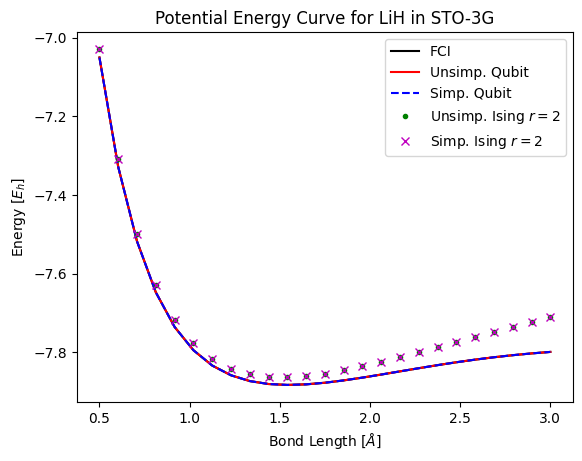

In [47]:
# and plot the results to compare

fig, ax = plt.subplots()

ax.plot(bond_lengths, fci_energies, "-k", label = "FCI")
ax.plot(bond_lengths, unsimp_qubit_energies, "-r", label = "Unsimp. Qubit")
ax.plot(bond_lengths, simp_qubit_energies, "--b", label = "Simp. Qubit")
ax.plot(bond_lengths, unsimp_ising_energies, ".g", label = "Unsimp. Ising $r=2$")
ax.plot(bond_lengths, simp_ising_energies, "xm", label = "Simp. Ising $r=2$")

ax.set_ylabel("Energy [$E_h$]")
ax.set_xlabel("Bond Length [$\\AA$]")
ax.set_title("Potential Energy Curve for LiH in STO-3G")
ax.legend(loc = "upper right")